In [1]:
# %pip install pandas -U
# %pip install numpy==1.20.3
# %pip install pyarrow -U
# %pip install tensorflow==2.11.0
# %pip install tensorflow_ranking
# %pip install tensorflow_recommenders
# %pip install tensorflow_addons
# %pip install tensorflow_io

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from typing import Dict, Tuple, Text
import math
import pickle

import os
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs
import tensorflow_addons as tfa
import tensorflow_io as tfio

print(f'{np.__version__=}')
print(f'{pd.__version__=}')

print(f'{tf.__version__=}')
print(f'{tfr.__version__=}')
print(f'{tfrs.__version__=}')
print(f'{tfa.__version__=}')
print(f'{tfio.__version__=}')

/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with th

np.__version__='1.20.3'
pd.__version__='1.5.2'
tf.__version__='2.11.0'
tfr.__version__='0.5.1.dev'
tfrs.__version__='v0.7.2'
tfa.__version__='0.19.0'
tfio.__version__='0.29.0'


In [3]:
CONFIG_TRAIN_DATA_PATH = '../data/train.parquet.gzip'
CONFIG_TEST_DATA_PATH = '../data/test.parquet.gzip'
CONFIG_META_DATA_PATH = '../data/items_meta.parquet.gzip'
CONFIG_ITEMS_NEW_DATA_PATH = '../data/fresh_candidates.parquet.gzip'

CONFIG_MODEL_CHECKPOINT_ROOT = '/home/jupyter/mnt/s3/vkcup2022/models'
CONFIG_MODEL_REPORT_ROOT = '/home/jupyter/mnt/s3/vkcup2022/reports'

In [4]:
def get_model_checkpoint_path_old(model_name: str) -> str:
    model_checkpoin_path = os.path.join(CONFIG_MODEL_CHECKPOINT_ROOT, model_name, 'checkpoint')
    print(f'get_model_checkpoint_path: {model_checkpoin_path}')
    return model_checkpoin_path

def get_model_checkpoint_path(model_name: str) -> str:
    os.makedirs(CONFIG_MODEL_CHECKPOINT_ROOT, exist_ok=True)    
    model_checkpoin_path = os.path.join(CONFIG_MODEL_CHECKPOINT_ROOT, model_name, '{epoch:02d}_checkpoint')
    print(f'get_model_checkpoint_path: {model_checkpoin_path}')
    return model_checkpoin_path

def get_model_checkpoint_path_by_epoch(model_name: str, epoch: int) -> str:
    model_checkpoin_path = os.path.join(CONFIG_MODEL_CHECKPOINT_ROOT, model_name, f'{epoch:02d}_checkpoint')
    print(f'get_model_checkpoint_path_by_epoch: model_name={model_name} epoch={epoch} -> {model_checkpoin_path}')
    return model_checkpoin_path

def get_model_report_path(model_name: str) -> str:
    os.makedirs(CONFIG_MODEL_REPORT_ROOT, exist_ok=True)
    model_report_path = os.path.join(CONFIG_MODEL_REPORT_ROOT, f'{model_name}_report.csv')
    print(f'get_model_report_path: {model_report_path}')
    return model_report_path

# Get data

In [5]:
user_id_count = 1000183
item_id_count = 227606
source_id_count = 24438
print(f'{user_id_count=}, {item_id_count=}, {source_id_count=}')

user_id_count=1000183, item_id_count=227606, source_id_count=24438


In [6]:
def get_new_item_id():
    print(f'get_new_item_id: loading new item_id list from {CONFIG_ITEMS_NEW_DATA_PATH}')
    item_id_new = pd.read_parquet(CONFIG_ITEMS_NEW_DATA_PATH).item_id.values
    return item_id_new

def get_new_item_id_dataset():
    return tf.data.Dataset.from_tensor_slices(get_new_item_id()).map(lambda x: tf.cast(x, tf.int32))

get_new_item_id().shape

get_new_item_id: loading new item_id list from ../data/fresh_candidates.parquet.gzip


(100000,)

In [7]:
class DataLoader:
    def __init__(self, folder_path='dataloader_short'):
        print(f'DataLoader:init:begin: {folder_path}')
        self.folder_path=folder_path
        
        os.makedirs(folder_path, exist_ok=True)
        self.train_train_data_file_path = os.path.join(folder_path, 'data_loader_train_train.parquet.gzip')
        self.train_valid_data_file_path = os.path.join(folder_path, 'data_loader_train_valid.parquet.gzip')
        self.test_data_file_path = os.path.join(folder_path, 'data_loader_test.parquet.gzip')
        
        self.train_train_item_id_history = os.path.join(folder_path, 'data_loader_train_train_item_id_history.npz')
        self.train_valid_item_id_history = os.path.join(folder_path, 'data_loader_train_valid_item_id_history.npz')
        self.test_item_id_history = os.path.join(folder_path, 'data_loader_test_item_id_history.npz')

        self.train_train_timespent_history = os.path.join(folder_path, 'data_loader_train_train_timespent_history.npz')
        self.train_valid_timespent_history = os.path.join(folder_path, 'data_loader_train_valid_timespent_history.npz')
        self.test_timespent_history = os.path.join(folder_path, 'data_loader_test_timespent_history.npz')    
        
        print(f'DataLoader:init:end')
                
    def build(self):
        print(f'DataLoader:prepare:begin')      
                
        print(f'loading train: {CONFIG_TRAIN_DATA_PATH}')
        train = pd.read_parquet(CONFIG_TRAIN_DATA_PATH)
        train['type'] = 0
        
        ###################################################################################
        # Найдем выборку для теста. Это будут последние записи для пользователей, которых нет в тестовой выборке 
        train_valid_size = 8192 * 4
        
        user_id_all = np.arange(user_id_count)
        user_id_new = get_new_item_id()
        user_id_old = user_id_all[~np.isin(user_id_all,user_id_new)]

        sample_size = train_valid_size
        np.random.seed(1000)        
        user_id_old_sample = np.random.choice(user_id_old, size=sample_size, replace=False)
        print(f'Выбрали {user_id_old_sample.shape} пользователей для валидации')
        
        train_sample = train[['user_id']][(train.timespent > 0) & (train.user_id.isin(user_id_old_sample))]
        print(f'unique = {train_sample.user_id.nunique()}')
        
        last_row_id_for_user_id_old_sample = np.array([i[-1] for i in train_sample.groupby('user_id').groups.values()])
        print(f'Выбрали {last_row_id_for_user_id_old_sample.shape} идентификаторов строк для валидации')
        train.loc[last_row_id_for_user_id_old_sample, 'type'] = 1 
        del user_id_all, user_id_new, user_id_old, train_sample, last_row_id_for_user_id_old_sample
        ###################################################################################        
                
        print(f'loading test: {CONFIG_TEST_DATA_PATH}')
        test = pd.read_parquet(CONFIG_TEST_DATA_PATH)
        test['item_id'] = -1
        test['timespent'] = 1  
        test['reaction'] = 0
        test['type'] = 2
        
        data = pd.concat([train, test]).reset_index(drop=True)
        del train, test     
        
        data_item_id_history, data_timespent_history = DataLoader.get_last_5_item_id(data)
        
        data = data[data.timespent > 0]
        
        train_train = data[data['type']==0].drop(columns=['type']).copy()
        train_train_item_id_history = data_item_id_history[train_train.index.values]
        train_train_timespent_history = data_timespent_history[train_train.index.values]        
        
        train_train.to_parquet(self.train_train_data_file_path, compression='gzip')
        self.save_object(train_train_item_id_history, self.train_train_item_id_history)
        self.save_object(train_train_timespent_history, self.train_train_timespent_history)
        
        train_valid = data[data['type']==1].drop(columns=['type']).copy()
        train_valid_item_id_history = data_item_id_history[train_valid.index.values]
        train_valid_timespent_history = data_timespent_history[train_valid.index.values] 
        
        train_valid.to_parquet(self.train_valid_data_file_path, compression='gzip')
        self.save_object(train_valid_item_id_history, self.train_valid_item_id_history)
        self.save_object(train_valid_timespent_history, self.train_valid_timespent_history)
        
        test = data[data['type']==2].drop(columns=['item_id','timespent','reaction','type']).copy()
        item_id_full_history = DataLoader.get_test_with_user_id_history()
        test = test.merge(item_id_full_history, left_on='user_id', right_index=True)
        
        test_item_id_history = data_item_id_history[test.index.values]
        test_timespent_history = data_timespent_history[test.index.values]  
        
        test.to_parquet(self.test_data_file_path, compression='gzip')
        self.save_object(test_item_id_history, self.test_item_id_history)
        self.save_object(test_timespent_history, self.test_timespent_history)
    
        print(f'DataLoader:prepare:end')       
        

        
    def get_last_5_item_id(data, window = 5):
        print(f'DataLoader:get_last_5_item_id:begin')                        
        last_item_id_by_user_id = np.ones((user_id_count, window), dtype='int') * item_id_count
        last_timespent_by_user_id = np.ones((user_id_count, window), dtype='int') * 1

        last_item_id_result = np.zeros((len(data), window), dtype='int')
        last_timespent_result = np.zeros((len(data), window), dtype='int')

        for i, row in enumerate(data[['user_id','item_id','timespent']].itertuples(index=False)):
            last_item_id_result[i,:] = last_item_id_by_user_id[row.user_id,:]
            last_timespent_result[i,:] = last_timespent_by_user_id[row.user_id,:] 

            last_item_id_by_user_id[row.user_id, 0:window-1] = last_item_id_by_user_id[row.user_id, 1:window]
            last_item_id_by_user_id[row.user_id, window-1] = row.item_id

            last_timespent_by_user_id[row.user_id, 0:window-1] = last_timespent_by_user_id[row.user_id, 1:window]
            last_timespent_by_user_id[row.user_id, window-1] = row.timespent               

        print(f'DataLoader:get_last_5_item_id:end')                            
        return last_item_id_result, last_timespent_result
    
    def get_test_with_user_id_history():
        print(f'DataLoader:get_test_with_user_id_history:begin')                        
        
        print(f'Loading train data: {CONFIG_TRAIN_DATA_PATH}')    
        train = pd.read_parquet(CONFIG_TRAIN_DATA_PATH, columns=['user_id', 'item_id'])
        print(train.shape)
        print(train.head())

        print(f'Loading test data: {CONFIG_TEST_DATA_PATH}')
        test = pd.read_parquet(CONFIG_TEST_DATA_PATH)
        print(test.head())       
        print(test.shape)

        print('Filter train by test only users')
        train = train[train.user_id.isin(test.user_id)]
        print(train.head())    
        print(train.shape)
        del test

        print('Group item history')
        train = train.groupby('user_id').item_id.apply(list).to_frame('item_id_full_history')
        print(train.head())    
        print(train.shape)

        print(f'DataLoader:get_test_with_user_id_history:end')                                
        return train    
    
    def get_item_dataset_v2(df, item_id_history, timespent_history):
        dataset = tf.data.Dataset.from_tensor_slices(
            {
                'row_id':df.index,
                'user_id':df.user_id,
                'item_id':df.item_id,
                'timespent':df.timespent,
                'reaction':df.reaction + 1,
                'item_id_history':item_id_history,
                'timespent_history':timespent_history,            
            })
        return dataset
    
    def get_train_train_dataset_v4(self, batch_size):
        print(f'DataLoader:get_train_train_dataset_v4:begin: {batch_size=}')        
        #######################################################################       
        print(f'DataLoader:get_train_train_dataset_v4: loading {self.train_train_data_file_path}')                
        df = pd.read_parquet(self.train_train_data_file_path).astype(np.int32)        
        item_id_history = self.load_object(self.train_train_item_id_history)
        timespent_history = self.load_object(self.train_train_timespent_history)           
        #######################################################################
        np.random.seed(10)
        i = np.arange(len(df))
        np.random.shuffle(i)
        df = df.iloc[i]
        item_id_history = item_id_history[i,:]
        timespent_history = timespent_history[i,:]        
        #######################################################################        
        print(f'DataLoader:get_train_train_dataset_v4:begin: {batch_size=}')
        dataset = DataLoader.get_item_dataset_v2(df,item_id_history, timespent_history)
        dataset = dataset.batch(batch_size*10)       
        dataset = dataset.cache()    
        dataset = dataset.unbatch()       
        dataset = dataset.shuffle(batch_size*10)        
        dataset = dataset.batch(batch_size, drop_remainder=True)       
        dataset = dataset.prefetch(tf.data.AUTOTUNE)    
        print('DataLoader:get_train_train_dataset_v4:end:')    
        return dataset      

    def get_train_valid_dataset_v2(self, batch_size):
        print(f'DataLoader:get_train_valid_dataset_v2:begin: {batch_size=}')
        #######################################################################
        print(f'DataLoader:get_train_valid_dataset_v2: loading {self.train_valid_data_file_path}')                        
        df = pd.read_parquet(self.train_valid_data_file_path).astype(np.int32)
        item_id_history = self.load_object(self.train_valid_item_id_history)
        timespent_history = self.load_object(self.train_valid_timespent_history)
        #######################################################################
        dataset = DataLoader.get_item_dataset_v2(df,item_id_history, timespent_history)
        dataset = dataset.batch(batch_size, drop_remainder=True)       
        dataset = dataset.prefetch(tf.data.AUTOTUNE)    
        print('DataLoader:get_train_valid_dataset_v2:end:')    
        return dataset 
    
    def get_test_dataframe(self):
        return pd.read_parquet(self.test_data_file_path, columns=['user_id'])
    
    def get_test_dataframe_full(self):
        return pd.read_parquet(self.test_data_file_path)    
    
    def get_test_dataset_v2(self, batch_size):
        print(f'DataLoader:get_test_dataset_v2:begin: {batch_size=}')
        #######################################################################
        df = pd.read_parquet(self.test_data_file_path)
        item_id_history = self.load_object(self.test_item_id_history)
        timespent_history = self.load_object(self.test_timespent_history)        
        #######################################################################            
        
        dataset = tf.data.Dataset.from_tensor_slices(
            {
                'user_id':df.user_id.astype(np.int32),
                'item_id_history':item_id_history,
                'timespent_history':timespent_history,
            })    
        dataset_item_id_full_history = tf.data.Dataset.from_generator(lambda: df.item_id_full_history, output_shapes=(None,), output_types=tf.int32)  

        def fn_add_history(item1, item2):
            item1['item_id_full_history'] = item2
            return item1
        dataset = tf.data.Dataset.zip((dataset, dataset_item_id_full_history)).map(fn_add_history)

        dataset = dataset.padded_batch(batch_size, padding_values={'user_id':None, 'item_id_history':None, 'timespent_history':None, 'item_id_full_history':tf.constant(-1, dtype=tf.int32)})
        dataset = dataset.prefetch(tf.data.AUTOTUNE)    
        print('DataLoader:get_test_dataset_v2:end:')    
        return dataset     
    
    def get_test_dataset_final(self, predictions, batch_size):
        print(f'DataLoader:get_test_dataset_final:begin: {batch_size=}')
        #######################################################################
        df = pd.read_parquet(self.test_data_file_path)
        item_id_history = self.load_object(self.test_item_id_history)
        timespent_history = self.load_object(self.test_timespent_history)              
        #######################################################################            
        dataset = tf.data.Dataset.from_tensor_slices(
            {
                'user_id':df.user_id.astype(np.int32),
                'item_id_history':item_id_history,
                'timespent_history':timespent_history,
                'predictions':predictions,
            })    

        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)    
        print('DataLoader:get_test_dataset_final:end:')    
        return dataset    
    
    def get_test_level2_df(self, test_predictions):
        print(f'DataLoader:get_test_level2_df:begin:')  
        
        df = pd.read_parquet(self.test_data_file_path).drop(columns=['item_id_full_history'])
        df['item_id_history'] = self.load_object(self.test_item_id_history).tolist()
        df['timespent_history'] = self.load_object(self.test_timespent_history).tolist()  
        df = df.merge(test_predictions[['user_id', 'predictions']], on='user_id', how='left') 
        df = df.explode('predictions').rename(columns={'predictions':'item_id'})
        
        print(f'DataLoader:get_test_level2_df:end:')                
        return df
    
    def get_test_dataset_level2(self, df, batch_size):
        print(f'DataLoader:get_test_dataset_final:begin: {batch_size=}')        
        dataset = tf.data.Dataset.from_tensor_slices(
            {
                'user_id':df.user_id.astype(np.int32),
                'item_id_history':tf.constant(df.item_id_history.tolist(), dtype=tf.int32),
                'timespent_history':tf.constant(df.timespent_history.tolist(), dtype=tf.int32),
                'item_id':df.item_id.astype(np.int32),
            })    
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset
    
    def save_object(self, obj, name):
        print(f'DataLoader:save_object:begin: {name=} {obj.shape=}')                
        np.savez_compressed(name, obj=obj)
        print(f'DataLoader:save_object:end')        

    def load_object(self, name):
        print(f'DataLoader:load_object:begin: {name=}')        
        loaded = np.load(name)
        obj = loaded['obj']
        print(f'DataLoader:load_object:end: {obj.shape=}')
        return obj

In [8]:
#!c1.8
data_loader = DataLoader()
data_loader.build()

DataLoader:init:begin: dataloader_short
DataLoader:init:end
DataLoader:prepare:begin
loading train: ../data/train.parquet.gzip
get_new_item_id: loading new item_id list from ../data/fresh_candidates.parquet.gzip
Выбрали (32768,) пользователей для валидации
unique = 32768
Выбрали (32768,) идентификаторов строк для валидации
loading test: ../data/test.parquet.gzip
DataLoader:get_last_5_item_id:begin
DataLoader:get_last_5_item_id:end
DataLoader:save_object:begin: name='dataloader_short/data_loader_train_train_item_id_history.npz' obj.shape=(23546702, 5)
DataLoader:save_object:end
DataLoader:save_object:begin: name='dataloader_short/data_loader_train_train_timespent_history.npz' obj.shape=(23546702, 5)
DataLoader:save_object:end
DataLoader:save_object:begin: name='dataloader_short/data_loader_train_valid_item_id_history.npz' obj.shape=(32768, 5)
DataLoader:save_object:end
DataLoader:save_object:begin: name='dataloader_short/data_loader_train_valid_timespent_history.npz' obj.shape=(32768, 5

# item_id mapping tables

In [9]:
class ItemsFeaturesModel:
    def __init__(self):
        super().__init__()

        train = pd.read_parquet(CONFIG_TRAIN_DATA_PATH)
        train_items_stat = train.groupby(['item_id','reaction']).size().unstack(level=1).fillna(0)
        train_items_stat.columns = ['neg', 'neutral', 'pos']
        train_items_stat['total'] = train_items_stat.sum(axis=1)
        
        train_items_stat['neg_to_neutral'] = (train_items_stat.neg / (train_items_stat.neutral + 1))
        train_items_stat['pos_to_neutral'] = (train_items_stat.pos / (train_items_stat.neutral + 1))
        train_items_stat['pos_to_neg'] = (train_items_stat.pos / (train_items_stat.neg + 1))
        train_items_stat['neutral_to_total'] = (train_items_stat.neutral / (train_items_stat.total + 1))

        params = {'neg':100,
                  'neutral':10,
                  'pos':100,
                  'total':10,
                  'neg_to_neutral':100,
                  'pos_to_neutral':100,
                  'pos_to_neg':100,
                  'neutral_to_total':20,
                 }
        
        bins_new = []
        for col, bins in params.items():
            print(f'col={col} bins={bins}')

            train_items_stat[col] = pd.qcut(train_items_stat[col], q=bins, retbins=False, labels=False, duplicates='drop')
            train_items_stat[col] = train_items_stat.groupby(col).ngroup()
            bins_new.append(train_items_stat[col].nunique())            

        self.item_id_features_map = tf.constant(train_items_stat.values, dtype=tf.int32)

        item_id = tf.keras.layers.Input(name='item_id', dtype=tf.int32, shape=())
        features_id_all = tf.keras.layers.Lambda(lambda x: tf.gather(self.item_id_features_map, x))(item_id)

        embedding_list = []
        for i, (col, bins) in enumerate(zip(params.keys(), bins_new)):
            emdedding_dim = round(np.sqrt(bins))+1
            print(f'feature {i:02} col={col} bins={bins} emdedding_dim={emdedding_dim}')
            feature_id = features_id_all[:,i]
            feature_embedding = tf.keras.layers.Embedding(bins, emdedding_dim)(feature_id)           
            embedding_list.append(feature_embedding)
            
        features_embedding = tf.concat(embedding_list, axis=-1)
#         x1 = tfrs.layers.dcn.Cross()(features_embedding, features_embedding)
#         x2 = tfrs.layers.dcn.Cross()(features_embedding, x1)        
#         features_embedding = x2
        self.model = tf.keras.Model(inputs=item_id, outputs=features_embedding, name='get_item_id_stat_features')
     
    def __call__(self, features) -> tf.Tensor:
        return self.model(features)

ItemsFeaturesModel()(tf.constant([0,1]))

2023-01-17 06:47:34.364805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 06:47:35.292626: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-17 06:47:38.479623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2023-01-17 06:47:38

col=neg bins=100
col=neutral bins=10
col=pos bins=100
col=total bins=10
col=neg_to_neutral bins=100
col=pos_to_neutral bins=100
col=pos_to_neg bins=100
col=neutral_to_total bins=20


2023-01-17 06:48:02.287459: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2023-01-17 06:48:02.287498: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


feature 00 col=neg bins=6 emdedding_dim=3
feature 01 col=neutral bins=10 emdedding_dim=4
feature 02 col=pos bins=21 emdedding_dim=6
feature 03 col=total bins=10 emdedding_dim=4
feature 04 col=neg_to_neutral bins=22 emdedding_dim=6
feature 05 col=pos_to_neutral bins=62 emdedding_dim=9
feature 06 col=pos_to_neg bins=27 emdedding_dim=6
feature 07 col=neutral_to_total bins=20 emdedding_dim=5


<tf.Tensor: shape=(2, 43), dtype=float32, numpy=
array([[-0.04321567,  0.03587705,  0.04728431,  0.01030605,  0.02305558,
         0.00305545,  0.02268312, -0.01747249,  0.04319118,  0.00836311,
         0.04466603,  0.03237144,  0.04549011,  0.02118548, -0.02938455,
         0.04954486,  0.01419853,  0.03012474,  0.04294084, -0.03512242,
         0.02964001,  0.04082492, -0.03886422, -0.02014476, -0.01179867,
        -0.02099332,  0.01488617,  0.04309689,  0.02100218,  0.04251646,
         0.02750904,  0.03333778,  0.00401454,  0.00462769,  0.01034806,
        -0.03532853,  0.00644613, -0.00996416, -0.00771091,  0.00473355,
         0.0455308 , -0.04618139, -0.04413335],
       [-0.04321567,  0.03587705,  0.04728431,  0.02892549, -0.04102933,
         0.03687557, -0.0270361 , -0.04344143, -0.04659208, -0.02863702,
        -0.02531847, -0.03752828, -0.0367128 ,  0.00061371, -0.0255868 ,
         0.00787774, -0.02393025,  0.03012474,  0.04294084, -0.03512242,
         0.02964001,  0.040

In [10]:
def get_content_embedding_by_item_id_mapping_table():
    print('get_content_embedding_by_item_id_mapping_table:begin:')
    embedding_matrix = pd.read_parquet(CONFIG_META_DATA_PATH, columns=['embeddings'])
    embedding_matrix = embedding_matrix.embeddings.tolist()
    embedding_matrix = np.array(embedding_matrix)
    embedding_matrix = np.vstack([embedding_matrix, np.mean(embedding_matrix,axis=0)])    
    print('get_content_embedding_by_item_id_mapping_table:end:')    
    return embedding_matrix

get_content_embedding_by_item_id_mapping_table().shape

get_content_embedding_by_item_id_mapping_table:begin:
get_content_embedding_by_item_id_mapping_table:end:


(227607, 312)

In [11]:
def get_source_id_by_item_id_mapping_table():
    print('get_source_id_by_item_id_mapping_table:begin:')
    source_id_by_item_id_mapping_table = pd.read_parquet(CONFIG_META_DATA_PATH, columns=['source_id']).source_id.values
    source_id_by_item_id_mapping_table = np.append(source_id_by_item_id_mapping_table, source_id_count)
    print('get_source_id_by_item_id_mapping_table:end:')
    return source_id_by_item_id_mapping_table

get_source_id_by_item_id_mapping_table()

get_source_id_by_item_id_mapping_table:begin:
get_source_id_by_item_id_mapping_table:end:


array([ 7340,  6284, 12766, ..., 20249,  8163, 24438])

In [12]:
# Item popularity
def get_probability_by_item_id_mapping_table():
    print(f'get_probability_by_item_id_mapping_table:begin')
    df = pd.read_parquet(CONFIG_TRAIN_DATA_PATH, columns=['item_id', 'timespent'])
    print(f'get_probability_by_item_id_mapping_table: {df.shape=}')
    df = df[df.timespent > 0]
    print(f'get_probability_by_item_id_mapping_table: {df.shape=}')
    
    probability_by_item_id_mapping_table = df[['item_id']].groupby('item_id').size().values
    probability_by_item_id_mapping_table = probability_by_item_id_mapping_table / np.sum(probability_by_item_id_mapping_table)
    print(f'get_probability_by_item_id_mapping_table: {probability_by_item_id_mapping_table.shape=}')

    print(f'get_probability_by_item_id_mapping_table:end')
    return probability_by_item_id_mapping_table

get_probability_by_item_id_mapping_table()

get_probability_by_item_id_mapping_table:begin
get_probability_by_item_id_mapping_table: df.shape=(144440015, 2)
get_probability_by_item_id_mapping_table: df.shape=(23579470, 2)
get_probability_by_item_id_mapping_table: probability_by_item_id_mapping_table.shape=(227606,)
get_probability_by_item_id_mapping_table:end


array([1.69639097e-07, 5.34363156e-06, 1.90843984e-06, ...,
       1.69639097e-07, 1.69639097e-07, 5.00435336e-06])

# Learning rate schedulers

In [13]:
def plot_schedulers(schedulers, n_steps):
    if not isinstance(schedulers, list):
        schedulers = [schedulers]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 3])
    for scheduler in schedulers:
        x = range(n_steps)
        y = [scheduler(i).numpy() for i in x]
        ax1.plot(x, y, label=scheduler.name)
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Learning Rate')
        ax1.legend()

        ax2.plot(x, y, label=scheduler.name)
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Learning Rate')
        ax2.set_yscale('log')
        ax2.legend()
    plt.show()

# Define model

In [14]:
from RetrievalCustomReward import RetrievalCustomReward # Исправляем ограничения на минимальную вероятность item_id в выборке

class FullModelMaskedZeros(tfrs.Model):
    def __init__(self, 
                 user_id_embedding_dim,
                 item_id_embedding_dim,
                 source_id_embedding_dim, 
                 user_layer_sizes,
                 item_layer_sizes,
                 rating_layer_sizes,
                 retrieval_weight=1., rating_loss_timespent_weight=1., rating_loss_reaction_weight=1.,
                 softmax_temperature=None,
                 remove_accidental_hits=False,
                 num_hard_negatives=None,
                ):
        super().__init__()
        
        self.retrieval_weight = retrieval_weight
        self.rating_loss_timespent_weight = rating_loss_timespent_weight
        self.rating_loss_reaction_weight = rating_loss_reaction_weight
        
        self.user_id_embedding_dim = user_id_embedding_dim
        self.item_id_embedding_dim = item_id_embedding_dim
        self.source_id_embedding_dim = source_id_embedding_dim
        self.content_id_embedding_dim = 312
        
        self.user_layer_sizes = user_layer_sizes
        self.item_layer_sizes = item_layer_sizes
        self.rating_layer_sizes = rating_layer_sizes
                
        # Define models
        self.init_shared_layers()
        self.user_model = self.get_user_model()
        self.item_model = self.get_item_model()
        self.rating_model = self.get_rating_model()

        # Define tasks
        item_id_dataset = tf.data.Dataset.range(item_id_count).map(lambda x: tf.cast(x, tf.int32))
        self.retrieval_task = RetrievalCustomReward(
            temperature = softmax_temperature,
            remove_accidental_hits = remove_accidental_hits,
            num_hard_negatives = num_hard_negatives,
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM),
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=item_id_dataset.batch(1024).map(self.item_model),
            )
        )
        
        self.rating_task_timespent: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        self.rating_task_reaction: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=None
        )
                
        self.loss_tracker_rating_loss_timespent = tf.keras.metrics.Mean(name="rating_loss_timespent")
        self.loss_tracker_rating_loss_reaction = tf.keras.metrics.Mean(name="rating_loss_reaction")
        self.loss_tracker_retrieval_loss = tf.keras.metrics.Mean(name="retrieval_loss")
        self.loss_tracker_regularization_loss = tf.keras.metrics.Mean(name="regularization_loss")
        self.loss_tracker_total_loss = tf.keras.metrics.Mean(name="total_loss")
            
    def init_shared_layers(self):
        print('FullModel:init_shared_layers:begin')       
        
        self.user_id_embedding_layer = tf.keras.layers.Embedding(
            user_id_count+1,
            self.user_id_embedding_dim,
            name='user_id_embedding',
        )
        
        self.item_id_embedding_layer = tf.keras.layers.Embedding(
            item_id_count+1, 
            self.item_id_embedding_dim,
            name='item_id_embedding',
        )
        
        self.source_id_embedding_layer = tf.keras.layers.Embedding(
            source_id_count+1,
            self.source_id_embedding_dim,
            name='source_id_embedding',
        )
        
        self.source_id_by_item_id_mapping_table = tf.constant(get_source_id_by_item_id_mapping_table(), dtype=tf.int32)        
        self.content_embedding_by_item_id_mapping_table = tf.constant(get_content_embedding_by_item_id_mapping_table(), dtype=tf.float32)
        self.probability_by_item_id_mapping_table = tf.constant(get_probability_by_item_id_mapping_table(), dtype=tf.float32)

        self.item_id_feature_model = ItemsFeaturesModel().model
        print('FullModel:init_shared_layers:end') 
        
    def get_user_model(self):
        print('FullModel:get_user_model:begin')
        
        user_id_input = tf.keras.Input(shape=(), name='user_id', dtype=tf.int32) 
        item_id_history_input = tf.keras.Input(shape=(5,), name='item_id_history_input', dtype=tf.int32) 
        timespent_history_input = tf.keras.Input(shape=(5,), name='timespent_history_input', dtype=tf.float32) 

        # Encoding user_id
        user_id_embedding = self.user_id_embedding_layer(user_id_input)
        
        # Encoding item history
        item_id_history_embedding = self.item_id_embedding_layer(item_id_history_input) 
        source_id_history = tf.keras.layers.Lambda(lambda x: tf.gather(self.source_id_by_item_id_mapping_table, x), name='get_source_id')(item_id_history_input)        
        source_id_history_embedding = self.source_id_embedding_layer(source_id_history)        
        content_history_embedding = tf.keras.layers.Lambda(lambda x: tf.gather(self.content_embedding_by_item_id_mapping_table, x), name='get_content_embedding')(item_id_history_input)
        timespent_flag_history_embedding = tf.keras.layers.Embedding(2, 1, name='timespent_flag')(tf.cast(timespent_history_input > 0, tf.int32)) # Embedding to show timespent > 0
        
        item_history_embedding = tf.concat(values=[item_id_history_embedding, source_id_history_embedding, content_history_embedding, timespent_flag_history_embedding], axis=-1)        
                
        # Create positional embedding.
        sequence_length = 5
        position_embedding_encoder = tf.keras.layers.Embedding(
            input_dim=sequence_length,
            output_dim=self.item_id_embedding_dim + self.source_id_embedding_dim + self.content_id_embedding_dim + 1,
            name="position_embedding",
        )
        
        positions = tf.range(start=0, limit=sequence_length, delta=1)
        encodded_positions = position_embedding_encoder(positions)
        
        # Retrieve sequence ratings to incorporate them into the encoding
        timespent_history = tf.expand_dims(tf.math.log(timespent_history_input + 2), -1)
                
        # Add the positional encoding to the item_id encodings and multiply them by rating.
        encoded_item_id_history_embedding_with_poistion_and_rating = tf.keras.layers.Multiply()(
            [(item_history_embedding + encodded_positions), timespent_history]
        ) 
        print(f'{encoded_item_id_history_embedding_with_poistion_and_rating.shape=}')
        
        dropout_rate = 0.1
        num_heads = 3
        
        transformer_features = encoded_item_id_history_embedding_with_poistion_and_rating
        other_features = user_id_embedding
        
        ############################################################################################
        # Create a multi-headed attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
        )(transformer_features, transformer_features)

        # Transformer block.
        attention_output = tf.keras.layers.Dropout(dropout_rate)(attention_output)
        x1 = tf.keras.layers.Add()([transformer_features, attention_output])
        x1 = tf.keras.layers.LayerNormalization()(x1)
        x2 = tf.keras.layers.LeakyReLU()(x1)
        x2 = tf.keras.layers.Dense(units=x2.shape[-1])(x2)
        x2 = tf.keras.layers.Dropout(dropout_rate)(x2)
        transformer_features = tf.keras.layers.Add()([x1, x2])
        transformer_features = tf.keras.layers.LayerNormalization()(transformer_features)
        ############################################################################################
#         features = tf.keras.layers.Flatten()(transformer_features) # Очень долго, надо попробовать если будет время        
        features = tf.keras.layers.GlobalAveragePooling1D()(transformer_features)
        ############################################################################################

        # Included the other features.
        if other_features is not None:
            features = tf.keras.layers.concatenate(
                [features, tf.keras.layers.Reshape([other_features.shape[-1]])(other_features)]
            )
            
        # Fully-connected layers.            
        for num_units in self.user_layer_sizes[:-1]:
            features = tf.keras.layers.Dense(num_units)(features)
            features = tf.keras.layers.BatchNormalization()(features)
            features = tf.keras.layers.LeakyReLU()(features)
            features = tf.keras.layers.Dropout(dropout_rate)(features)
            
        for num_units in self.user_layer_sizes[-1:]:
            features = tf.keras.layers.Dense(num_units)(features)            

        ############################################################################################

        print('TextRetrievalModel:get_user_model:end')                
        return tf.keras.Model(
            inputs={
                'user_id':user_id_input,
                'item_id_history':item_id_history_input,
                'timespent_history':timespent_history_input
            },
            outputs=features, name='user_model')    
    
    def get_item_model(self):
        print('FullModel:get_item_model:begin')  
        
        dropout_rate = 0.1     
        
        item_id_input = tf.keras.Input(shape=(), name='item_id', dtype=tf.int32)   
        item_id_embedding = self.item_id_embedding_layer(item_id_input)

        source_id = tf.keras.layers.Lambda(lambda x: tf.gather(self.source_id_by_item_id_mapping_table, x), name='get_source_id')(item_id_input)
        source_id_embedding = self.source_id_embedding_layer(source_id)

        content_embedding = tf.keras.layers.Lambda(lambda x: tf.gather(self.content_embedding_by_item_id_mapping_table, x), name='get_content_embedding')(item_id_input)
        
        item_stat_embedding = self.item_id_feature_model(item_id_input) # item_stat_embedding
        
        features = tf.concat(values=[item_id_embedding, source_id_embedding, content_embedding, item_stat_embedding], axis=-1)
        
        # Fully-connected layers.
        for num_units in self.item_layer_sizes[:-1]:
            features = tf.keras.layers.Dense(num_units)(features)
            features = tf.keras.layers.BatchNormalization()(features)
            features = tf.keras.layers.LeakyReLU()(features)
            features = tf.keras.layers.Dropout(dropout_rate)(features)
            
        for num_units in self.item_layer_sizes[-1:]:
            features = tf.keras.layers.Dense(num_units)(features)
        
        print('TextRetrievalModel:get_item_model:end')                
        return tf.keras.Model(inputs=item_id_input, outputs=features, name='item_model')
    
    def get_rating_model(self):
        print('FullModel:get_rating_model:begin')        
        full_embedding_input = tf.keras.Input(shape=(self.user_layer_sizes[-1] + self.item_layer_sizes[-1]), name='full_embedding_input', dtype=tf.float32)  
        
        dropout_rate = 0.1    
        
        features = full_embedding_input
        
        # Fully-connected layers.
        for num_units in self.rating_layer_sizes:
            features = tf.keras.layers.Dense(num_units)(features)
            features = tf.keras.layers.BatchNormalization()(features)
            features = tf.keras.layers.LeakyReLU()(features)
            features = tf.keras.layers.Dropout(dropout_rate)(features)

        timespent = tf.keras.layers.Dense(1, activation='sigmoid', name='timespent')(features)
        timespent = timespent * 60
        
        reaction = tf.keras.layers.Dense(3, activation='softmax', name='reaction')(features)
        
        print('FullModel:get_rating_model:end')        
        return tf.keras.Model(inputs=full_embedding_input, outputs=[timespent, reaction], name='rating_model')    
    
    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        user_embedding = self.user_model(features)
        item_embedding = self.item_model(features["item_id"])
        
        timespent_pred, reaction_pred = self.rating_model(tf.concat([user_embedding, item_embedding], axis=1))
        return (user_embedding, item_embedding, timespent_pred, reaction_pred)         

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        timespent, reaction, row_id = features.pop("timespent"), features.pop("reaction"), features.pop("row_id")
        user_embedding, item_embedding, timespent_pred, reaction_pred = self(features)
        
        history_weight = 0.5 + 0.5 * tf.cast(row_id, tf.float32) / 144440014.
        
        rating_loss_timespent = self.rating_task_timespent(
            labels=timespent,
            predictions=timespent_pred,
            sample_weight=tf.expand_dims(history_weight, axis=-1),
        )
        
        rating_loss_reaction = self.rating_task_reaction(
            labels=reaction,
            predictions=reaction_pred,
            sample_weight=tf.expand_dims(history_weight, axis=-1),
        ) 

        timespent_weight = tf.math.log1p(tf.cast(timespent, tf.float32))

        retrieval_loss = self.retrieval_task(
            query_embeddings=user_embedding,
            candidate_embeddings=item_embedding, 
            candidate_ids=features['item_id'],
            rewards=timespent,
            compute_metrics=not training, 
            sample_weight = history_weight * timespent_weight,
            candidate_sampling_probability=tf.gather(self.probability_by_item_id_mapping_table, features["item_id"])
        )
        
        return rating_loss_timespent, rating_loss_reaction, retrieval_loss

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            rating_loss_timespent, rating_loss_reaction, retrieval_loss = self.compute_loss(inputs, training=True)
            regularization_loss = sum(self.losses)
            total_loss = self.rating_loss_timespent_weight * rating_loss_timespent + self.rating_loss_reaction_weight * rating_loss_reaction + self.retrieval_weight * retrieval_loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.loss_tracker_rating_loss_timespent.update_state(rating_loss_timespent)        
        self.loss_tracker_rating_loss_reaction.update_state(rating_loss_reaction)                
        self.loss_tracker_retrieval_loss.update_state(retrieval_loss)        
        self.loss_tracker_regularization_loss.update_state(regularization_loss)        
        self.loss_tracker_total_loss.update_state(total_loss)            

        metrics = {metric.name: metric.result() for metric in self.metrics}
        return metrics

    def test_step(self, inputs):
        rating_loss_timespent, rating_loss_reaction, retrieval_loss = self.compute_loss(inputs, training=False)
        regularization_loss = sum(self.losses)
        total_loss = self.rating_loss_timespent_weight * rating_loss_timespent + self.rating_loss_reaction_weight * rating_loss_reaction + self.retrieval_weight * retrieval_loss + regularization_loss
        
        self.loss_tracker_rating_loss_timespent.update_state(rating_loss_timespent)        
        self.loss_tracker_rating_loss_reaction.update_state(rating_loss_reaction)                
        self.loss_tracker_retrieval_loss.update_state(retrieval_loss)        
        self.loss_tracker_regularization_loss.update_state(regularization_loss)        
        self.loss_tracker_total_loss.update_state(total_loss)           

        metrics = {metric.name: metric.result() for metric in self.metrics}
        return metrics
    
def check_model():
    model = FullModelMaskedZeros(
        user_id_embedding_dim=64,
        item_id_embedding_dim=64,
        source_id_embedding_dim=64,      
        user_layer_sizes = [256, 128, 64], 
        item_layer_sizes = [128, 64],
        rating_layer_sizes = [64, 32],
        softmax_temperature=0.05,
        remove_accidental_hits=True,
        num_hard_negatives=None,
        retrieval_weight=1., rating_loss_timespent_weight=100., rating_loss_reaction_weight=10.,                      
    )  
    
    print(model.user_model.summary(expand_nested=True))
    tf.keras.utils.plot_model(model.user_model, show_shapes=True, show_dtype=True, expand_nested=True, to_file='user_model.png')

    print(model.item_model.summary(expand_nested=True))
    tf.keras.utils.plot_model(model.item_model, show_shapes=True, show_dtype=True, expand_nested=True, to_file='item_model.png')
    
    print(model.rating_model.summary(expand_nested=True))
    tf.keras.utils.plot_model(model.rating_model, show_shapes=True, show_dtype=True, expand_nested=True, to_file='rating_model.png')    

check_model()

FullModel:init_shared_layers:begin
get_source_id_by_item_id_mapping_table:begin:
get_source_id_by_item_id_mapping_table:end:
get_content_embedding_by_item_id_mapping_table:begin:
get_content_embedding_by_item_id_mapping_table:end:
get_probability_by_item_id_mapping_table:begin
get_probability_by_item_id_mapping_table: df.shape=(144440015, 2)
get_probability_by_item_id_mapping_table: df.shape=(23579470, 2)
get_probability_by_item_id_mapping_table: probability_by_item_id_mapping_table.shape=(227606,)
get_probability_by_item_id_mapping_table:end
col=neg bins=100
col=neutral bins=10
col=pos bins=100
col=total bins=10
col=neg_to_neutral bins=100
col=pos_to_neutral bins=100
col=pos_to_neg bins=100
col=neutral_to_total bins=20
feature 00 col=neg bins=6 emdedding_dim=3
feature 01 col=neutral bins=10 emdedding_dim=4
feature 02 col=pos bins=21 emdedding_dim=6
feature 03 col=total bins=10 emdedding_dim=4
feature 04 col=neg_to_neutral bins=22 emdedding_dim=6
feature 05 col=pos_to_neutral bins=62 e

In [15]:
def get_callbacks(model_name):
    return [
        tf.keras.callbacks.CSVLogger(get_model_report_path(model_name)),
        tf.keras.callbacks.ModelCheckpoint(
            filepath = get_model_checkpoint_path(model_name),   
            verbose=1,
            save_best_only=False,
            save_weights_only=True,
            save_freq='epoch'),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_total_loss',
            mode='min',
            verbose=1,    
            patience=4,
            restore_best_weights=True),
    ]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


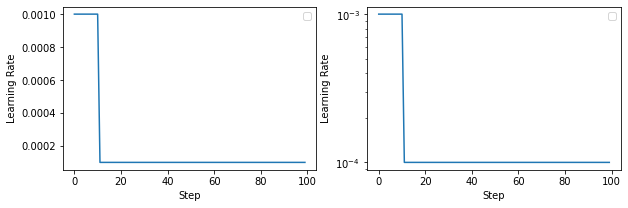

In [16]:
epochs = 10
steps_per_epoch = 10

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([steps_per_epoch, steps_per_epoch*3, ], [1e-3, 1e-4, 1e-4])

# lr and wd can be a function or a tensor
lr = schedule(step)
wd = lambda: 0.1 * schedule(step)
optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
plot_schedulers(schedule, steps_per_epoch * epochs)

Background cell scheduled. Waiting for foreground cells to finish commits
Preparing g1.1 instance...
g1.1 instance is ready, running task...


2023-01-17 06:49:53.075177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 06:49:59.649263: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2023-01-17 06:49:59.649747: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/

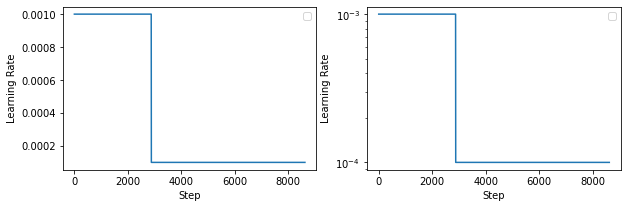

FullModel:init_shared_layers:begin
get_source_id_by_item_id_mapping_table:begin:
get_source_id_by_item_id_mapping_table:end:
get_content_embedding_by_item_id_mapping_table:begin:
get_content_embedding_by_item_id_mapping_table:end:
get_probability_by_item_id_mapping_table:begin
get_probability_by_item_id_mapping_table: df.shape=(144440015, 2)
get_probability_by_item_id_mapping_table: df.shape=(23579470, 2)
get_probability_by_item_id_mapping_table: probability_by_item_id_mapping_table.shape=(227606,)
get_probability_by_item_id_mapping_table:end
col=neg bins=100
col=neutral bins=10
col=pos bins=100
col=total bins=10
col=neg_to_neutral bins=100
col=pos_to_neutral bins=100
col=pos_to_neg bins=100
col=neutral_to_total bins=20
feature 00 col=neg bins=6 emdedding_dim=3
feature 01 col=neutral bins=10 emdedding_dim=4
feature 02 col=pos bins=21 emdedding_dim=6
feature 03 col=total bins=10 emdedding_dim=4
feature 04 col=neg_to_neutral bins=22 emdedding_dim=6
feature 05 col=pos_to_neutral bins=62 e

/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


   2874/Unknown - 598s 195ms/step - rating_loss_timespent: 4.3830 - rating_loss_reaction: 0.1353 - retrieval_loss: 50220.6641 - regularization_loss: 0.0000e+00 - total_loss: 50794.3008 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 2.4112

/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089

Epoch 1: saving model to /home/jupyter/mnt/s3/vkcup2022/models/user_id_vs_item_id_v82_att_AdamW_scheduler2_64_stat_flag_fix/01_checkpoint
2875/2875 [==============================] - 711s 234ms/step - rating_loss_timespent: 4.3830 - rating_loss_reaction: 0.1353 - retrieval_loss: 50220.6641 - regularization_loss: 0.0000e+00 - total_loss: 50794.3008 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 2.4112 - val_rating_loss_timespent: 5.1635 - val_rating_loss_reaction: 0.1134 - val_retrieval_loss: 63191.9922 - val_regulariza

In [17]:
#!g1.1
#pragma async

model_name = 'user_id_vs_item_id_v82_att_AdamW_scheduler2_64_stat_flag_fix'
batch_size = 8192

epochs = 3
steps_per_epoch = 2875

###############################################################################
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([steps_per_epoch, steps_per_epoch*3, ], [1e-3, 1e-4, 1e-4])

# lr and wd can be a function or a tensor
lr = schedule(step)
wd = lambda: 0.1 * schedule(step)
optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
plot_schedulers(schedule, steps_per_epoch * epochs)
###############################################################################

def train_model():
    model = FullModelMaskedZeros(
        user_id_embedding_dim=64,
        item_id_embedding_dim=64,
        source_id_embedding_dim=64,      
        user_layer_sizes = [256, 128, 64], 
        item_layer_sizes = [128, 64],
        rating_layer_sizes = [64, 32],      
        softmax_temperature=0.05,
        remove_accidental_hits=True,
        num_hard_negatives=None,
        retrieval_weight=1., rating_loss_timespent_weight=100., rating_loss_reaction_weight=1000.,                
    )    
    
    model.compile(optimizer=optimizer)    
    model.fit(data_loader.get_train_train_dataset_v4(batch_size),
              validation_data = data_loader.get_train_valid_dataset_v2(batch_size).cache(),
              epochs=epochs,
              callbacks = get_callbacks(model_name))

train_model()

# Prediction

In [18]:
model_name = 'user_id_vs_item_id_v82_att_AdamW_scheduler2_64_stat_flag_fix'
epoch = 3

model1_hist_size = 20

def process_predict(model_name, epoch, model1_hist_size):
    print('process_predict:begin')
    
    print(f'process_predict: loading new item_id list from {CONFIG_ITEMS_NEW_DATA_PATH}')
    items_new = pd.read_parquet(CONFIG_ITEMS_NEW_DATA_PATH)
    print(items_new.head)    
    print(items_new.shape)
    
    item_id_new_dataset = tf.data.Dataset.from_tensor_slices(get_new_item_id()).map(lambda x: tf.cast(x, tf.int32))
    
    print(f'process_predict: Loading model')
    model = FullModelMaskedZeros(
        user_id_embedding_dim=64,
        item_id_embedding_dim=64,
        source_id_embedding_dim=64,      
        user_layer_sizes = [256, 128, 64], 
        item_layer_sizes = [128, 64],
        rating_layer_sizes = [64, 32],      
        softmax_temperature=0.05,
        remove_accidental_hits=True,
        num_hard_negatives=None,
        retrieval_weight=1., rating_loss_timespent_weight=100., rating_loss_reaction_weight=1000.,                
    ) 
    model.load_weights(get_model_checkpoint_path_by_epoch(model_name, epoch=epoch))

    print(f'process_predict: Loading index')    
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model, k=model1_hist_size)
    index.index_from_dataset(tf.data.Dataset.zip((item_id_new_dataset.batch(128), item_id_new_dataset.batch(128).map(model.item_model))))
    
    print(f'process_predict: Prediction')
    item_id_pred_full = []
    for item in tqdm(data_loader.get_test_dataset_v2(1024)):
        score, item_id_pred = index.query_with_exclusions(
            queries=item,
            exclusions=item['item_id_full_history'])
        item_id_pred_full.append(item_id_pred.numpy())
        
    print('Collecting results')
    item_id_pred_full = np.vstack(item_id_pred_full)

    test = data_loader.get_test_dataframe()
    test['predictions'] = item_id_pred_full.tolist()
    
    print('process_predict:end')    
    return test

test = process_predict(model_name, epoch, model1_hist_size)
test[['user_id', 'predictions']].to_parquet(f'submit_{model_name}_{epoch}_hist.parquet.gzip', compression='gzip')

process_predict:begin
process_predict: loading new item_id list from ../data/fresh_candidates.parquet.gzip
<bound method NDFrame.head of        item_id
0            0
1            2
2            5
3            6
4            7
...        ...
99995   227588
99996   227591
99997   227602
99998   227603
99999   227605

[100000 rows x 1 columns]>
(100000, 1)


2023-01-17 07:44:55.150839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 07:44:56.210384: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-17 07:44:59.813909: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2023-01-17 07:44:59

get_new_item_id: loading new item_id list from ../data/fresh_candidates.parquet.gzip


2023-01-17 07:45:06.909350: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2023-01-17 07:45:06.909386: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
process_predict: Loading model
FullModel:init_shared_layers:begin
get_source_id_by_item_id_mapping_table:begin:
get_source_id_by_item_id_mapping_table:end:
get_content_embedding_by_item_id_mapping_table:begin:
get_content_embedding_by_item_id_mapping_table:end:
get_probability_by_item_id_mapping_table:begin
get_probability_by_item_id_mapping_table: df.shape=(144440015, 2)
get_probability_by_item_id_mapping_table: df.shape=(23579470, 2)
get_probability_by_item_id_mapping_table: probability_by_item_id_mapping_table.shape=(227606,)
get_probability_by_item_id_mapping_table:end
col=neg bins=100
col=neutral bins=10
col=pos bins=100
col=total bins=10
col=neg_to_neutral bins=100
col=pos_to_neutral bins=100
col=pos_to_neg bins=100
col=neutral_to_total bins=20
feature 00 col=neg bins=6 emdedding_di

/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id_full_history'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id_full_history'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id_full_history'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id_full_history'] which did not match any model input. They wil

/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id_full_history'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id_full_history'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id_full_history'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id_full_history'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/jupyter/.local/lib/python3.8/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['item_id_full_history'] which did not match any model input. They wil


process_predict:end
